# Análise de Erros do Modelo de CAPTCHA
Este notebook mostra exemplos de erros do modelo, matrizes de confusão e estatísticas dos erros no conjunto de teste.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import string
DATASET_TEST = '../dataset/test'
MODEL_PATH = '../captcha_model.h5'
CHARS = string.ascii_uppercase + string.digits

In [2]:
def get_labels_and_images(dataset_path):
    files = [f for f in os.listdir(dataset_path) if f.endswith('.png')]
    labels = [os.path.splitext(f)[0] for f in files]
    images = []
    for f in files:
        img = Image.open(os.path.join(dataset_path, f)).convert('L').resize((200, 60))
        img = np.array(img) / 255.0
        img = img[..., np.newaxis]  # adiciona canal
        images.append(img)
    return np.array(images), labels, files

X_test, y_true_str, test_files = get_labels_and_images(DATASET_TEST)

In [3]:
model = tf.keras.models.load_model(MODEL_PATH)
Y_pred = model.predict(X_test)
y_pred = np.stack([np.argmax(Y_pred[i], axis=1) for i in range(5)], axis=1)
# Corrige: só aceita labels válidos (5 caracteres, todos em CHARS)
valid_labels = []
valid_indices = []
for idx, label in enumerate(y_true_str):
    label_up = label.upper()
    if len(label_up) == 5 and all(c in CHARS for c in label_up):
        indices = [CHARS.index(c) for c in label_up]
        valid_labels.append(indices)
        valid_indices.append(idx)
y_true = np.array(valid_labels)
X_test = X_test[valid_indices]
y_pred = y_pred[valid_indices]
test_files = [test_files[i] for i in valid_indices]

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


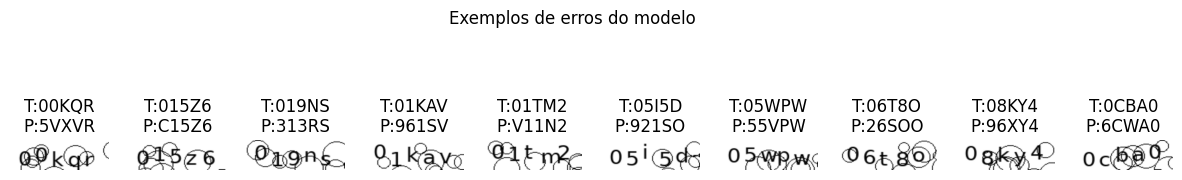

In [4]:
n = 10
shown = 0
plt.figure(figsize=(15,3))
for idx in range(len(X_test)):
    if not np.all(y_true[idx] == y_pred[idx]):
        plt.subplot(1, n, shown+1)
        plt.imshow(X_test[idx].squeeze(), cmap='gray')
        true_str = ''.join([CHARS[c] for c in y_true[idx]])
        pred_str = ''.join([CHARS[c] for c in y_pred[idx]])
        plt.title(f'T:{true_str}\nP:{pred_str}')
        plt.axis('off')
        shown += 1
        if shown >= n: break
plt.suptitle('Exemplos de erros do modelo')
plt.show()

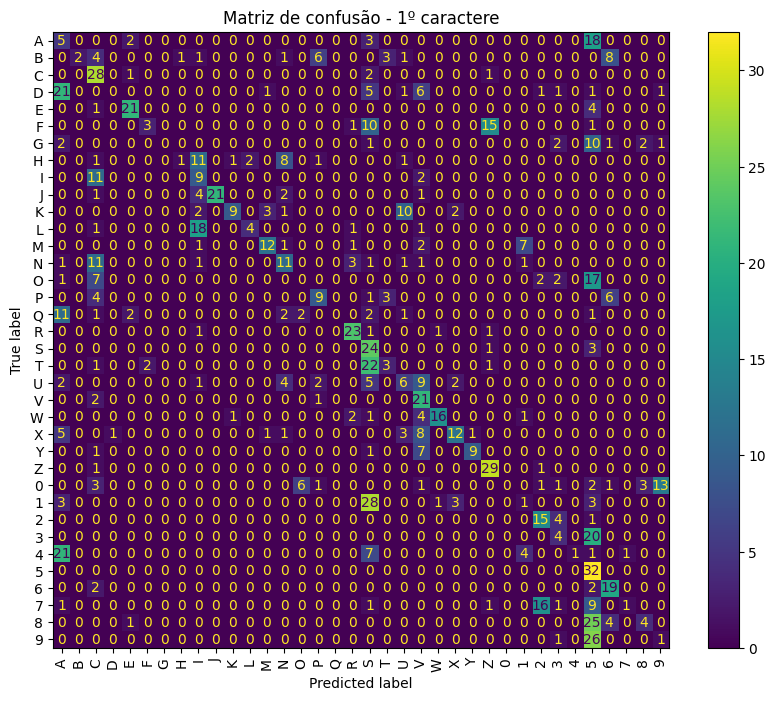

In [5]:
i = 0  # posição do caractere
classes_presentes = np.unique(np.concatenate([y_true[:, i], y_pred[:, i]]))
labels_usados = [CHARS[j] for j in classes_presentes]
cm = confusion_matrix(y_true[:, i], y_pred[:, i], labels=classes_presentes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_usados)
fig, ax = plt.subplots(figsize=(10,8))
disp.plot(ax=ax, xticks_rotation='vertical')
plt.title('Matriz de confusão - 1º caractere')
plt.show()